Connected to my_env (Python 3.9.18)

In [ ]:
peak_bed_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/Oth.Emb.05.AllAg.AllCell.bed"

In [ ]:
import pandas as pd

In [ ]:
import pybedtools
peak_bed = pybedtools.BedTool(peak_bed_file)


In [ ]:
peak_bed_df = peak_bed.to_dataframe()
peak_bed_nohead = peak_bed_df.iloc[1:, :].dropna()

In [ ]:
def extract_gene_name(name):
    return name.split("Name=")[1].split("%")[0]

In [ ]:
peak_bed_nohead["gene_name"] = peak_bed_nohead["name"].apply(extract_gene_name)

In [ ]:
peak_bed_cleaned = peak_bed_nohead[["chrom", "start", "end", "gene_name"]].rename(columns={"gene_name": "gene_id"})

In [ ]:
def format_peak_id(chrom, start, end):
    start = str(int(start))
    end = str(int(end))
    return "%s:%s-%s" % (chrom, start, end)

In [ ]:
peak_bed_cleaned["peak_id"] = peak_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)

In [ ]:
peak_bed_final = peak_bed_cleaned[["gene_id", "peak_id"]]

In [ ]:
peak_bed_final.head()

,gene_id,peak_id
1,Smad4,chr1:3003564-3003922
2,Ctcf,chr1:3012605-3012815
3,Ctcf,chr1:3012635-3012824
4,Epitope,chr1:3031387-3031654
5,Smad4,chr1:3031454-3031677


In [ ]:
peak_bed_final.to_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/chipatlas_mESC.csv", header=True, index=False)

In [ ]:
peak_df = peak_bed_cleaned[["peak_id", "chrom", "start", "end"]]

In [ ]:
peak_df = peak_df.rename(columns={"peak_id":"PeakID", "chrom":"chr"})

In [ ]:
peak_df["strand"] = ["."] * len(peak_df)

In [ ]:
peak_df.to_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/DS011_mESC_sample1/chipatlas_peak_df.csv", header=True, index=False)

In [ ]:
peak_df["start"] = peak_df["start"].astype(int).astype(str)

In [ ]:
peak_df["end"] = peak_df["end"].astype(int).astype(str)

In [ ]:
peak_df.to_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/DS011_mESC_sample1/chipatlas_peak_df.csv", header=True, index=False)

In [ ]:
from grn_inference.pipeline.sliding_window_tf_peak_motifs import (
    find_ATAC_peak_sequence,
    associate_tf_with_motif_pwm,
    plot_feature_score_histogram
)

In [ ]:
reference_genome_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/reference_genome/mm10"
parsed_peak_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/peak_sequences.pkl"
fig_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC"

In [ ]:
peak_df["end"] = peak_df["end"].astype(int)

In [ ]:
peak_df["start"] = peak_df["start"].astype(int)

100%|██████████| 66/66 [01:20<00:00,  1.22s/it]


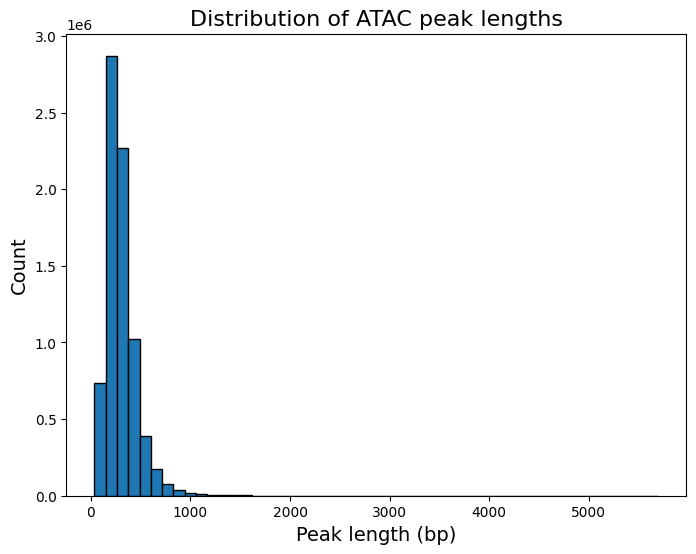

In [ ]:
chr_pos_to_seq = find_ATAC_peak_sequence(peak_df, reference_genome_dir, parsed_peak_file, fig_dir)

In [ ]:
chr_pos_to_seq.to_pickle(parsed_peak_file)

In [ ]:
tf_names_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/motif_information/mm10/TF_Information_all_motifs.txt"
meme_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/motif_information/mm10/mm10_motif_meme_files"
rna_data_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/DS011_mESC_sample1/DS011_mESC_RNA_processed.parquet"

In [ ]:
rna_df = pd.read_parquet(rna_data_file, columns=["gene_id"])

In [ ]:
rna_data_genes = set(rna_df)

In [ ]:
species = "mm10"

In [ ]:
num_cpu = 8

In [ ]:
output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC"

In [ ]:
reference_genome_dir

'/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/reference_genome/mm10'

In [ ]:
chr_pos_to_seq.shape

(7624391, 6)

In [ ]:
parsed_peak_file

'/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/peak_sequences.pkl'

In [ ]:
chr_pos_to_seq

,chr,start,end,+ seq,- seq,peak_len
7624321,chrY_JH584301_random,3140,3201,"[3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...",61
7624322,chrY_JH584301_random,10651,10718,"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, ...",67
7624323,chrY_JH584301_random,13373,13454,"[3, 1, 3, 0, 3, 1, 3, 0, 3, 1, 3, 0, 3, 1, 3, ...","[0, 2, 0, 3, 0, 2, 0, 3, 0, 2, 0, 3, 0, 2, 0, ...",81
7624324,chrY_JH584301_random,28862,28977,"[1, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, ...","[2, 0, 3, 0, 2, 0, 3, 0, 3, 0, 2, 0, 3, 0, 2, ...",115
7624325,chrY_JH584301_random,56821,56874,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, ...",53
...,...,...,...,...,...,...
7412181,chrUn_GL456372,28244,28554,"[3, 1, 0, 2, 3, 3, 2, 2, 3, 1, 0, 1, 0, 3, 2, ...","[0, 2, 3, 1, 0, 0, 1, 1, 0, 2, 3, 2, 3, 0, 1, ...",310
7412182,chrUn_GL456372,28310,28538,"[1, 0, 3, 3, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, ...","[2, 3, 0, 0, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, ...",228
7412183,chrUn_GL456372,28323,28499,"[0, 0, 3, 0, 1, 3, 2, 1, 0, 1, 3, 1, 1, 1, 0, ...","[3, 3, 0, 3, 2, 0, 1, 2, 3, 2, 0, 2, 2, 2, 3, ...",176
7412184,chrUn_GL456372,28347,28543,"[1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 3, 0, 2, 0, ...","[2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 0, 0, 3, 1, 3, ...",196


In [ ]:
chr_pos_to_seq_sample = chr_pos_to_seq.sample(frac=0.1)

In [ ]:
chr_pos_to_seq_sample

,chr,start,end,+ seq,- seq,peak_len
3722124,chr19,56919658,56919882,"[0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 3, 3, 1, 3, 2, ...","[3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 0, 0, 2, 0, 1, ...",224
319073,chr1,135699420,135699638,"[2, 2, 1, 1, 2, 2, 1, 0, 3, 0, 3, 3, 0, 2, 0, ...","[1, 1, 2, 2, 1, 1, 2, 3, 0, 3, 0, 0, 3, 1, 3, ...",218
3495030,chr18,77986416,77986691,"[3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 2, 3, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 1, 0, 2, 2, 2, ...",275
6967971,chr8,126065166,126065409,"[0, 2, 1, 1, 0, 1, 0, 3, 2, 2, 3, 3, 3, 1, 3, ...","[3, 1, 2, 2, 3, 2, 3, 0, 1, 1, 0, 0, 0, 2, 0, ...",243
3962992,chr2,74683130,74683378,"[1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, ...","[2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, ...",248
...,...,...,...,...,...,...
1857547,chr13,48965457,48965806,"[0, 0, 3, 1, 3, 2, 0, 0, 2, 3, 0, 0, 3, 0, 3, ...","[3, 3, 0, 2, 0, 1, 3, 3, 1, 0, 3, 3, 0, 3, 0, ...",349
4541284,chr3,95450524,95450815,"[1, 3, 0, 3, 0, 3, 2, 1, 0, 1, 0, 1, 0, 1, 3, ...","[2, 0, 3, 0, 3, 0, 1, 2, 3, 2, 3, 2, 3, 2, 0, ...",291
5816379,chr6,47787829,47788218,"[3, 1, 1, 3, 3, 3, 0, 1, 3, 2, 3, 1, 3, 3, 0, ...","[0, 2, 2, 0, 0, 0, 3, 2, 0, 1, 0, 2, 0, 0, 3, ...",389
7165032,chr9,60243571,60243916,"[0, 3, 3, 3, 1, 0, 0, 0, 0, 0, 3, 2, 1, 3, 3, ...","[3, 0, 0, 0, 2, 3, 3, 3, 3, 3, 0, 1, 2, 0, 0, ...",345


In [ ]:
chr_pos_to_seq_sample = chr_pos_to_seq.sample(frac=0.05)

In [ ]:
chr_pos_to_seq_sample

,chr,start,end,+ seq,- seq,peak_len
266850,chr1,120120951,120121405,"[0, 3, 0, 1, 3, 2, 2, 3, 2, 0, 2, 2, 3, 2, 0, ...","[3, 0, 3, 2, 0, 1, 1, 0, 1, 3, 1, 1, 0, 1, 3, ...",454
5142549,chr4,141858634,141858846,"[3, 1, 3, 2, 2, 2, 2, 0, 1, 0, 3, 3, 2, 3, 0, ...","[0, 2, 0, 1, 1, 1, 1, 3, 2, 3, 0, 0, 1, 0, 3, ...",212
2077717,chr14,7901879,7902070,"[1, 1, 0, 2, 2, 2, 1, 0, 0, 1, 0, 3, 2, 1, 0, ...","[2, 2, 3, 1, 1, 1, 2, 3, 3, 2, 3, 0, 1, 2, 3, ...",191
7249767,chr9,78845255,78845622,"[3, 2, 0, 1, 3, 3, 1, 3, 3, 2, 0, 0, 1, 3, 2, ...","[0, 1, 3, 2, 0, 0, 2, 0, 0, 1, 3, 3, 2, 0, 1, ...",367
45188,chr1,30740921,30741149,"[3, 0, 3, 0, 0, 3, 2, 3, 2, 3, 3, 3, 0, 0, 2, ...","[0, 3, 0, 3, 3, 0, 1, 0, 1, 0, 0, 0, 3, 3, 1, ...",228
...,...,...,...,...,...,...
7308990,chr9,102714953,102715070,"[2, 0, 3, 0, 1, 3, 0, 2, 3, 1, 2, 2, 1, 3, 3, ...","[1, 3, 0, 3, 2, 0, 3, 1, 0, 2, 1, 1, 2, 0, 0, ...",117
1280541,chr11,100744986,100745401,"[3, 2, 0, 0, 3, 3, 2, 2, 3, 3, 2, 3, 0, 3, 2, ...","[0, 1, 3, 3, 0, 0, 1, 1, 0, 0, 1, 0, 3, 0, 1, ...",415
1036341,chr11,52765964,52766359,"[0, 3, 2, 1, 3, 2, 3, 1, 1, 3, 3, 3, 2, 2, 3, ...","[3, 0, 1, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, ...",395
6421192,chr7,102076752,102077090,"[0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, ...","[3, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, ...",338


In [ ]:
chr_pos_to_seq_sample.to_pickle("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/tmp/peak_sequences.pkl")

In [ ]:
chr_pos_to_seq_sample = chr_pos_to_seq.sample(frac=0.001)

In [ ]:
chr_pos_to_seq_sample

,chr,start,end,+ seq,- seq,peak_len
4919508,chr4,88763406,88763801,"[1, 3, 2, 3, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 2, ...","[2, 0, 1, 0, 3, 2, 1, 2, 1, 3, 3, 1, 1, 1, 1, ...",395
3554566,chr19,7020504,7020645,"[0, 1, 0, 3, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, ...","[3, 2, 3, 0, 2, 3, 3, 2, 2, 2, 3, 3, 3, 1, 2, ...",141
1575433,chr12,75596165,75596570,"[1, 0, 0, 3, 2, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, ...","[2, 3, 3, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, ...",405
6264022,chr7,45561276,45561669,"[1, 2, 1, 1, 3, 2, 1, 1, 0, 2, 0, 0, 3, 3, 2, ...","[2, 1, 2, 2, 0, 1, 2, 2, 3, 1, 3, 3, 0, 0, 1, ...",393
6483812,chr7,122623819,122624055,"[0, 0, 2, 0, 1, 2, 3, 3, 3, 1, 1, 1, 0, 2, 2, ...","[3, 3, 1, 3, 2, 1, 0, 0, 0, 2, 2, 2, 3, 1, 1, ...",236
...,...,...,...,...,...,...
5162398,chr4,148626601,148627169,"[1, 3, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2, ...","[2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 3, 1, ...",568
7220415,chr9,71074009,71074259,"[3, 0, 0, 3, 3, 0, 0, 3, 2, 2, 2, 2, 2, 2, 0, ...","[0, 3, 3, 0, 0, 3, 3, 0, 1, 1, 1, 1, 1, 1, 3, ...",250
6186468,chr7,25133143,25133473,"[1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 3, 0, 2, 0, 0, ...","[2, 3, 1, 3, 1, 3, 2, 3, 1, 2, 0, 3, 1, 3, 3, ...",330
3611240,chr19,26213590,26213841,"[0, 3, 3, 0, 3, 1, 3, 3, 0, 2, 3, 3, 1, 3, 1, ...","[3, 0, 0, 3, 0, 2, 0, 0, 3, 1, 0, 0, 2, 0, 2, ...",251


In [ ]:
chr_pos_to_seq_sample.to_pickle("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/tmp/peak_sequences.pkl")

In [ ]:
sliding_window_df = pd.read_parquet("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/sliding_window_tf_to_peak_score.parquet", engine="pyarrow")

In [ ]:
sliding_window_df.head()

,peak_id,source_id,sliding_window_score
__null_dask_index__,,,
0,chr4:88763406-88763801,Ahctf1,0.431384
1,chr19:7020504-7020645,Ahctf1,0.196823
2,chr12:75596165-75596570,Ahctf1,0.425570
3,chr7:45561276-45561669,Ahctf1,0.494738
4,chr7:122623819-122624055,Ahctf1,0.322769


In [ ]:
sliding_window_df.reset_index()

,__null_dask_index__,peak_id,source_id,sliding_window_score
0,0,chr4:88763406-88763801,Ahctf1,0.431384
1,1,chr19:7020504-7020645,Ahctf1,0.196823
2,2,chr12:75596165-75596570,Ahctf1,0.425570
3,3,chr7:45561276-45561669,Ahctf1,0.494738
4,4,chr7:122623819-122624055,Ahctf1,0.322769
...,...,...,...,...
21142107,7619,chr4:148626601-148627169,Dnajc21,0.940842
21142108,7620,chr9:71074009-71074259,Dnajc21,0.474462
21142109,7621,chr7:25133143-25133473,Dnajc21,0.617293
21142110,7622,chr19:26213590-26213841,Dnajc21,0.473546


In [ ]:
sliding_window_df = sliding_window_df[["peak_id", "source_id", "sliding_window_score"]]

In [ ]:
peak_bed_sub = peak_bed_final[peak_bed_final["gene_id"].isin(sliding_window_df["peak_id"])]

In [ ]:
peak_bed_final

,gene_id,peak_id
1,Smad4,chr1:3003564-3003922
2,Ctcf,chr1:3012605-3012815
3,Ctcf,chr1:3012635-3012824
4,Epitope,chr1:3031387-3031654
5,Smad4,chr1:3031454-3031677
...,...,...
7624387,Rest,chrY_JH584303_random:135985-136047
7624388,Rest,chrY_JH584303_random:135985-136048
7624389,Rest,chrY_JH584303_random:135986-136045
7624390,Rest,chrY_JH584303_random:135989-136043


In [ ]:
peak_bed_sub = peak_bed_final[peak_bed_final["peak_id"].isin(sliding_window_df["peak_id"])]

In [ ]:
peak_bed_sub

,gene_id,peak_id
30,Cebpa,chr1:3059708-3059807
43,Ncor2,chr1:3094784-3095161
50,Ncor2,chr1:3094854-3095103
63,Ncor2,chr1:3113649-3113870
96,Ncor2,chr1:3120165-3120649
...,...,...
7624325,Rest,chrY_JH584301_random:56821-56874
7624328,Rest,chrY_JH584301_random:56826-56874
7624342,Epitope,chrY_JH584301_random:130529-130620
7624360,Atrx,chrY_JH584301_random:206615-206677


In [ ]:
merged_df = pd.merge(peak_bed_sub, sliding_window_df, on="peak_id", how="inner")

In [ ]:
merged_df

,gene_id,peak_id,source_id,sliding_window_score
0,Cebpa,chr1:3059708-3059807,Arid5a,0.172386
1,Cebpa,chr1:3059708-3059807,Ebf4,0.000000
2,Cebpa,chr1:3059708-3059807,Egr1,0.218335
3,Cebpa,chr1:3059708-3059807,Elf2,0.236552
4,Cebpa,chr1:3059708-3059807,Emx2,0.164790
...,...,...,...,...
21845742,Rest,chrY_JH584302_random:139711-139760,Zfp182,0.000000
21845743,Rest,chrY_JH584302_random:139711-139760,Zfp282,0.041938
21845744,Rest,chrY_JH584302_random:139711-139760,Zfp653,0.166139
21845745,Rest,chrY_JH584302_random:139711-139760,Zfp692,0.100401


In [ ]:
merged_df = merged_df.rename(columns={"gene_id": "chip_gene", "source_id": "sliding_window_gene"})

In [ ]:
merged_df = merged_df[["chip_gene", "sliding_window_gene", "peak_id", "sliding_window_score"]]

In [ ]:
merged_df

,chip_gene,sliding_window_gene,peak_id,sliding_window_score
0,Cebpa,Arid5a,chr1:3059708-3059807,0.172386
1,Cebpa,Ebf4,chr1:3059708-3059807,0.000000
2,Cebpa,Egr1,chr1:3059708-3059807,0.218335
3,Cebpa,Elf2,chr1:3059708-3059807,0.236552
4,Cebpa,Emx2,chr1:3059708-3059807,0.164790
...,...,...,...,...
21845742,Rest,Zfp182,chrY_JH584302_random:139711-139760,0.000000
21845743,Rest,Zfp282,chrY_JH584302_random:139711-139760,0.041938
21845744,Rest,Zfp653,chrY_JH584302_random:139711-139760,0.166139
21845745,Rest,Zfp692,chrY_JH584302_random:139711-139760,0.100401


In [ ]:
merged_df.to_csv("chipseq_sliding_window_merged.csv", header=True, index=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("chipseq_sliding_window_merged.csv", header=0, index_col=None)

In [ ]:
correct_predictions = df[df["chip_gene"] == df["sliding_window_gene"]]
incorrect_predictions = df[df["chip_gene"] != df["sliding_window_gene"]]

In [ ]:
correct_prediction_scores = correct_predictions["sliding_window_score"].sample(min(len(correct_predictions), len(incorrect_predictions)))
incorrect_prediction_scores = incorrect_predictions["sliding_window_score"].sample(min(len(correct_predictions), len(incorrect_predictions)))

In [ ]:
correct_prediction_scores = correct_prediction_scores.rename("Correct Predictions")
incorrect_prediction_scores = incorrect_prediction_scores.rename("Inorrect Predictions")

In [ ]:
correct_prediction_scores = correct_prediction_scores.reset_index(drop=True)
incorrect_prediction_scores = incorrect_prediction_scores.reset_index(drop=True)

In [ ]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, left_index=True, right_index=True)

In [ ]:
pred_df = pred_df.rename(columns={"Inorrect Predictions":"Incorrect Predictions"})

Text(0.5, 1.0, 'Sliding Window Scores for ChIP-seq TF Binding Predictions')

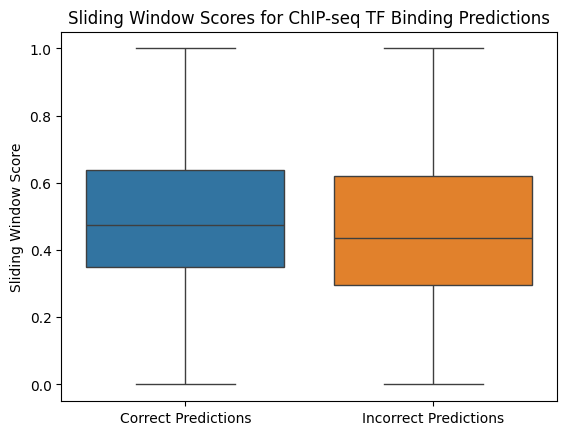

In [ ]:
fig = plt.Figure()
a = sns.boxplot(data=pred_df)
a.set_ylabel("Sliding Window Score")
a.set_title("Sliding Window Scores for ChIP-seq TF Binding Predictions")

In [ ]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, left_index=True, right_index=True)

In [ ]:
pred_df = pred_df.rename(columns={"Inorrect Predictions":"Incorrect Predictions"})

In [ ]:
pred_df = pred_df.rename(columns={
    "Correct TF Binding":"Correct TF Binding Location",
    "Incorrect TF Binding":"Incorrect TF Binding Location"
    })

In [ ]:
fig.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/figures/chipseq_sliding_window_boxplot.png", dpi=200)